In [ ]:
import numpy as np
from scipy.integrate import quad

# Constants
me = 9.11e-28
c = 3.0e10
kb = 1.38e-16
hbar = 1.054e-27
mp = 1.67e-24
Q = 2.531
Kweak = 6.5e-4
eV = 1.602e-12
Msun = 2.0e33
G = 6.67e-8
arad = 7.56e-15


In [ ]:
# Set density/temperature grid for EOS
rhomin = 1.0e5
rhomax = 1.0e12
rhoprec = 100
rhorun = np.logspace(np.log10(rhomin), np.log10(rhomax), rhoprec)

tempmin = 1e7
tempmax = 1e11
tempprec = 100
temprun = np.logspace(np.log10(tempmin), np.log10(tempmax), tempprec)

# Initialize 2D arrays
temp2D, rho2D = np.meshgrid(temprun, rhorun, indexing="ij")

P_tabletest = rho2D*kb/mp*temp2D + arad*temp2D**4/3

U_tabletest = 1.5*rho2D*kb/mp*temp2D + arad*temp2D**4

#Eddington Equation of State

### 1. We can compute other thermal quantities as a function of $\rho$, T from P($\rho$, T), U($\rho$, T). For instance, $\gamma \equiv \frac{\partial P}{\partial \rho}|_s \frac{\rho}{P}$ is calculated below.


In [ ]:
def compute_dPdrho_S(rho, T, P_table, U_table, edge_order =2):
    """
    Compute (∂P/∂rho)|_S using the derived thermodynamic relation.

    Parameters:
    rho      : 1D array of density values
    T        : 1D array of temperature values
    P_table  : 2D array of pressure values (P(T, rho))
    U_table  : 2D array of internal energy per volume (U(T, rho))

    Returns:
    dPdrho_S : 2D array of (∂P/∂rho)|_S values
    """
    # Create 2D mesh of rho values to match dimensions
    rho_2D = np.tile(rho, (len(T), 1))  # Now matches P_table shape (T, rho)

    # Compute derivatives with respect to rho (axis=1) and T (axis=0)
    dP_drho_T = np.zeros_like(P_table)
    dU_drho_T = np.zeros_like(U_table)
    dP_dT_rho = np.zeros_like(P_table)
    dU_dT_rho = np.zeros_like(U_table)

    # Calculate derivatives for each T value (rows)
    for i in range(len(T)):
        dP_drho_T[i, :] = np.gradient(P_table[i, :], rho, edge_order=edge_order)
        dU_drho_T[i, :] = np.gradient(U_table[i, :], rho, edge_order=edge_order)
        ### If you set edge_order=2, then boundary values use second-order accurate (quadratic) formulas instead of linear approximations
        ### # Second-order at endpoints
            # df_edge2[0]     = (-3*f[0] + 4*f[1] - f[2]) / (2*dx)
            # df_edge2[-1]    = ( 3*f[-1] - 4*f[-2] + f[-3]) / (2*dx)
            # # Central difference inside
            # for i in range(1, len(f)-1):
            #     df_edge2[i] = (f[i+1] - f[i-1]) / (2*dx)

    # Calculate derivatives for each rho value (columns)
    for j in range(len(rho)):
        dP_dT_rho[:, j] = np.gradient(P_table[:, j], T, edge_order=edge_order)
        dU_dT_rho[:, j] = np.gradient(U_table[:, j], T, edge_order=edge_order)

    # Compute (∂P/∂U)_rho
    dP_dU_rho = dP_dT_rho / dU_dT_rho

    # Compute (∂P/∂rho)|_S using the thermodynamic relation
    # (∂P/∂rho)|_S = (∂P/∂rho)|_T + (∂P/∂U)|_rho * [(U+P)/rho - (∂U/∂rho)|_T]
    U_plus_P_over_rho = (U_table + P_table) / rho_2D

    dPdrho_S = dP_drho_T + dP_dU_rho * (U_plus_P_over_rho - dU_drho_T)

    return dPdrho_S


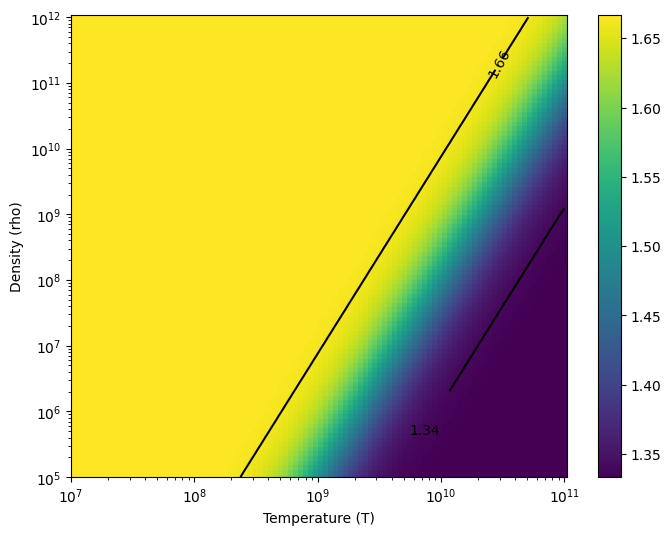

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

gammatottest = compute_dPdrho_S(rho2D[0], temp2D.T[0], P_tabletest, U_tabletest) / P_tabletest * rho2D

# Plotting contours
plt.figure(figsize=(8, 6))

# Background color mesh
plt.pcolormesh(temp2D, rho2D, gammatottest, shading='auto')  # Added `shading='auto'` for better compatibility
plt.colorbar()

# Contour lines
levels = [1.34, 1.66]
contours = plt.contour(temp2D, rho2D, gammatottest, levels=levels, colors='k')  # changed colormap to black lines

# Add labels to contours
plt.clabel(contours, contours.levels, inline=True, fmt='%1.2f', fontsize=10)


# Axis labels
plt.ylabel('Density (rho)')
plt.xlabel('Temperature (T)')
plt.xscale("log")
plt.yscale("log")

# Title
#plt.title(r'Gamma Contours in $\rho$-T Parameter Space')


plt.savefig("gamma_contours.pdf", format="pdf", bbox_inches='tight')
# Show plot
plt.show()


#### We calculate the differentiation ourselves using higher order methods.



Instead of using the built-in python function np.gradient(), which only implements the 2nd-order central scheme with either 1st-order or 2nd-order accuracy at the boundary.

We write our own function that implements various methods of different orders, including forward, backward, 2nd-order central and also 4th-other central methods. We compare the accuracy of the 2nd-order central method using np.gradient() and the 4th-order central method we implemented for a specific example by calculating the L2 error and its dependence on the grid spacing.

Also note that the non-uniform spacing make it hard to implement our own differentiation since the standard interpolation methods (those we use in class) assume equal spacing.  


Here our solution is to take advantage of the fact that the grid is log-spaced, which a common case in hydrodynamic simulations since the thermal qunatities such as P and U can span over orders of magnitudes. We first calculate the differetian $\frac{\partial f}{\partial \ln\rho}$ and than derive $\frac{\partial f}{\partial \rho}$ using the chain rule $\frac{\partial f}{\partial \rho} = \frac{\partial f}{\partial \ln\rho} \frac{1}{\rho} $.

In [ ]:
### Note that the fact that rho, T are not equally spaced making manual implementation tricky.
### But we can take advantage of the fact that log rho, log T are equally spaced (usual case in dealing with such questions).
### So, this function is suited for dealling with log rho, log T equally spaced. For other cases, np.gradient could be better.
def differentiate_loggrid_1D(f, rho, method="central"):
    """
    Differentiate f(rho) when log(rho) is equally spaced.

    Parameters:
    f : array_like
        Function values sampled at rho points.
    rho : array_like
        Original rho points (log-spaced).
    method : str
        Finite difference method: 'central', 'forward', 'backward', 'fourth_order_central'

    Returns:
    df_drho : array_like
        Approximated df/drho.
    """
    log_rho = np.log(rho)
    dlog_rho = log_rho[1] - log_rho[0]  # uniform spacing in log_rho
    df_dlogrho = np.zeros_like(f)

    if method == "central":
        for i in range(1, len(f)-1):
            df_dlogrho[i] = (f[i+1] - f[i-1]) / (2*dlog_rho)
        # 2nd-order one-sided differences at boundaries
        df_dlogrho[0] = (-3*f[0] + 4*f[1] - f[2]) / (2*dlog_rho)
        df_dlogrho[-1] = (3*f[-1] - 4*f[-2] + f[-3]) / (2*dlog_rho)

    elif method == "forward":
        for i in range(len(f)-1):
            df_dlogrho[i] = (f[i+1] - f[i]) / dlog_rho
        df_dlogrho[-1] = (f[-1] - f[-2]) / dlog_rho

    elif method == "backward":
        for i in range(1, len(f)):
            df_dlogrho[i] = (f[i] - f[i-1]) / dlog_rho
        df_dlogrho[0] = (f[1] - f[0]) / dlog_rho


    elif method == "fourth_order_central":
        if len(f) < 6:
            raise ValueError("Need at least 6 points for fourth-order method.")

        # 4th-order one-sided differences at i=0 and i=N-1
        df_dlogrho[0] = (-25*f[0] + 48*f[1] - 36*f[2] + 16*f[3] - 3*f[4]) / (12*dlog_rho)
        df_dlogrho[-1] = (25*f[-1] - 48*f[-2] + 36*f[-3] - 16*f[-4] + 3*f[-5]) / (12*dlog_rho)

        # 4th-order near-boundary points i=1 and i=N-2
        df_dlogrho[1] = (-3*f[0] - 10*f[1] + 18*f[2] - 6*f[3] + f[4]) / (12*dlog_rho)
        df_dlogrho[-2] = (3*f[-1] + 10*f[-2] - 18*f[-3] + 6*f[-4] - f[-5]) / (12*dlog_rho)

        # 4th-order central inside
        for i in range(2, len(f)-2):
            df_dlogrho[i] = (-f[i+2] + 8*f[i+1] - 8*f[i-1] + f[i-2]) / (12*dlog_rho)

    else:
        raise ValueError(f"Unknown method: {method}")

    # Convert back: df/drho = (1/rho) * df/dlogrho
    df_drho = df_dlogrho / rho

    return df_drho



def compute_dPdrho_Sv2(rho, T, P_table, U_table, method="central"):
    """
    Compute (∂P/∂rho)|_S using the derived thermodynamic relation.

    Parameters:
    rho      : 1D array of density values
    T        : 1D array of temperature values
    P_table  : 2D array of pressure values (P(T, rho))
    U_table  : 2D array of internal energy per volume (U(T, rho))

    Returns:
    dPdrho_S : 2D array of (∂P/∂rho)|_S values
    """
    # Create 2D mesh of rho values to match dimensions
    rho_2D = np.tile(rho, (len(T), 1))  # Now matches P_table shape (T, rho)

    # Compute derivatives with respect to rho (axis=1) and T (axis=0)
    dP_drho_T = np.zeros_like(P_table)
    dU_drho_T = np.zeros_like(U_table)
    dP_dT_rho = np.zeros_like(P_table)
    dU_dT_rho = np.zeros_like(U_table)

    # Calculate derivatives for each T value (rows)
    for i in range(len(T)):
        dP_drho_T[i, :] = differentiate_loggrid_1D(P_table[i, :], rho, method)
        dU_drho_T[i, :] = differentiate_loggrid_1D(U_table[i, :], rho, method)



    # Calculate derivatives for each rho value (columns)
    for j in range(len(rho)):
        dP_dT_rho[:, j] = differentiate_loggrid_1D(P_table[:, j], T, method)
        dU_dT_rho[:, j] = differentiate_loggrid_1D(U_table[:, j], T, method)


    # Compute (∂P/∂U)_rho
    dP_dU_rho = dP_dT_rho / dU_dT_rho

    # Compute (∂P/∂rho)|_S using the thermodynamic relation
    # (∂P/∂rho)|_S = (∂P/∂rho)|_T + (∂P/∂U)|_rho * [(U+P)/rho - (∂U/∂rho)|_T]
    U_plus_P_over_rho = (U_table + P_table) / rho_2D

    dPdrho_S = dP_drho_T + dP_dU_rho * (U_plus_P_over_rho - dU_drho_T)

    return dPdrho_S


To compare the accuracy, we use the Eddington Equation of State as an example and derive an analytical expression of Gamma.

In [ ]:
### Compute (∂P/∂rho)_S analytically for the Eddington Equation of State for test
def dPdrho_S_exact(rho, T):
    """
    Compute (∂P/∂rho)_S analytically for the Eddington Equation of State,
    using dPdrho_S = dP_drho_T + dP_dU_rho * (U_plus_P_over_rho - dU_drho_T)

    Parameters:
    rho : array_like
        Density values.
    T : array_like
        Temperature values.
    kb : float
        Boltzmann constant.
    mp : float
        Mass per particle.
    arad : float
        Radiation constant.

    Returns:
    dPdrho_S : array_like
        Analytical values of (∂P/∂rho)_S.
    """

    # Terms to simplify the expression
    A = kb / mp
    B = arad

    # Precompute frequently used terms
    term1 = A * T  # (kB/mp) * T

    numerator = rho * A + (4.0/3.0) * B * T**3
    denominator = (3.0/2.0) * rho * A + 4.0 * B * T**3

    bracket = A * T + (4.0/3.0) * B * T**4 / rho

    dPdrho_S = term1 + (numerator / denominator) * bracket

    return dPdrho_S


Compare the accuracy of the two methods: 2nd order central and 4th order central.

In [ ]:
# Set density/temperature grid for EOS
err1 = []
err2 = []
Ns = np.array([100, 200, 500, 1000])

for N in Ns:

    rhoprec = N
    rhorun = np.logspace(np.log10(rhomin), np.log10(rhomax), rhoprec)

    tempprec = N
    temprun = np.logspace(np.log10(tempmin), np.log10(tempmax), tempprec)


    # Initialize 2D arrays
    temp2D, rho2D = np.meshgrid(temprun, rhorun, indexing="ij")

    P_tabletest = rho2D*kb/mp*temp2D + arad*temp2D**4/3

    U_tabletest = 1.5*rho2D*kb/mp*temp2D + arad*temp2D**4

    gamma_exact = dPdrho_S_exact(rho2D, temp2D)/P_tabletest*rho2D


    gammatottest = compute_dPdrho_Sv2(rho2D[0],temp2D.T[0], P_tabletest, U_tabletest)/P_tabletest*rho2D
    gammatottestv2 = compute_dPdrho_Sv2(rho2D[0],temp2D.T[0], P_tabletest, U_tabletest, "fourth_order_central")/P_tabletest*rho2D

    err1.append(np.sqrt(np.mean((gammatottest - gamma_exact)**2)))
    err2.append(np.sqrt(np.mean((gammatottestv2 - gamma_exact)**2)))


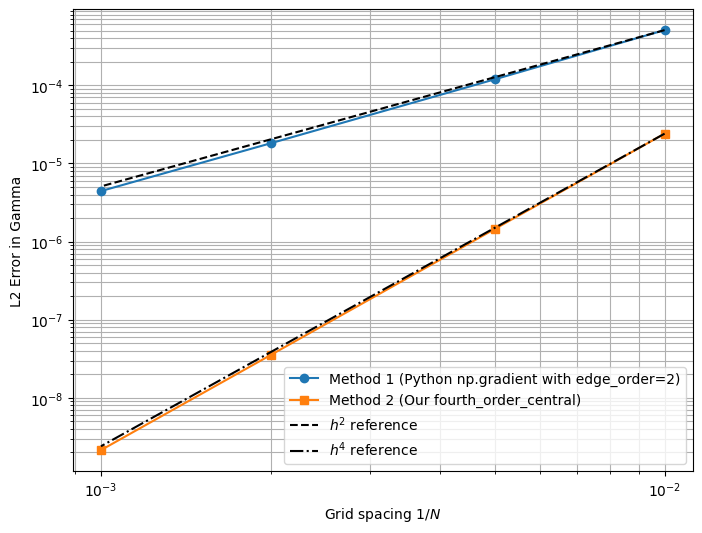

In [ ]:

h = 1.0 / Ns  # 1/N
err1 = np.array(err1)
err2 = np.array(err2)

# Plot
plt.figure(figsize=(8,6))
plt.loglog(h, err1, 'o-', label='Method 1 (Python np.gradient with edge_order=2)')
plt.loglog(h, err2, 's-', label='Method 2 (Our fourth_order_central)')

# Plot reference lines for second-order and fourth-order scaling
plt.loglog(h, err1[0]*(h/h[0])**2, 'k--', label=r'$h^2$ reference')
plt.loglog(h, err2[0]*(h/h[0])**4, 'k-.', label=r'$h^4$ reference')

plt.xlabel(r'Grid spacing $1/N$')
plt.ylabel('L2 Error in Gamma')
#plt.title('Comparison of accuracy in Gamma')

plt.grid(True, which='both')
plt.legend()
#plt.savefig("gamma_accuracy.pdf", format="pdf", bbox_inches='tight')
plt.show()

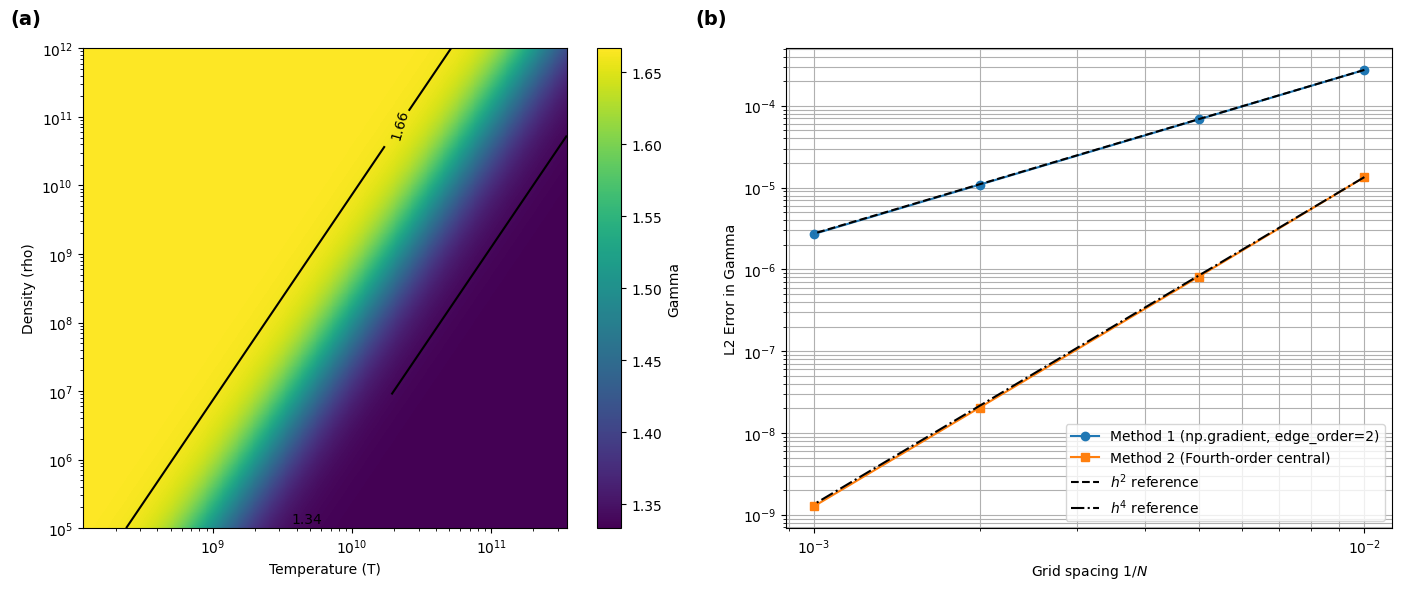

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ---- (a) Gamma Contours ----
#gammatottest = compute_dPdrho_S(rho2D[0], temp2D.T[0], P_tabletest, U_tabletest) / P_tabletest * rho2D

pcm = axs[0].pcolormesh(temp2D, rho2D, gammatottest, shading='auto', rasterized=True)
contours = axs[0].contour(temp2D, rho2D, gammatottest, levels=[1.34, 1.66], colors='k')
axs[0].clabel(contours, inline=True, fmt='%1.2f', fontsize=10)
fig.colorbar(pcm, ax=axs[0], label='Gamma')

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Temperature (T)')
axs[0].set_ylabel('Density (rho)')

# ---- (b) Gamma Accuracy ----
h = 1.0 / Ns
err1 = np.array(err1)
err2 = np.array(err2)

axs[1].loglog(h, err1, 'o-', label='Method 1 (np.gradient, edge_order=2)')
axs[1].loglog(h, err2, 's-', label='Method 2 (Fourth-order central)')
axs[1].loglog(h, err1[0]*(h/h[0])**2, 'k--', label=r'$h^2$ reference')
axs[1].loglog(h, err2[0]*(h/h[0])**4, 'k-.', label=r'$h^4$ reference')

axs[1].set_xlabel(r'Grid spacing $1/N$')
axs[1].set_ylabel('L2 Error in Gamma')
axs[1].grid(True, which='both')
axs[1].legend()

# ---- Subfigure labels outside top left corner ----
axs[0].annotate("(a)", xy=(-0.15, 1.05), xycoords='axes fraction', fontsize=14, fontweight='bold')
axs[1].annotate("(b)", xy=(-0.15, 1.05), xycoords='axes fraction', fontsize=14, fontweight='bold')

# ---- Save and show ----
plt.tight_layout()
plt.savefig("combined_gamma_plot.pdf", bbox_inches='tight')
plt.show()


### 2. Derive direct mapping of $U(P, \rho)$ and $P(U, \rho)$

Here we need to first derive T ($\rho$, P), T ($\rho$, U). And we need to do interpolation to get from the P, U values at the target points.

We use two different methods "linear" and "cubic" for interpolations and compare their accuracy including dependence on the step size.

In [ ]:
# Define interpolation from density and temperature

from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import root_scalar
#### Here we use "linear" interpolation
method = "linear"
method2d = "linear"
logreginterpE = RegularGridInterpolator((np.log10(rho2D[0]),np.log10(temp2D.T[0])), np.log10(U_tabletest.T), method = method, bounds_error=False, fill_value=None)
#### JJ: E and U have the same meaning. Can be changed to one symbol
logreginterpP = RegularGridInterpolator((np.log10(rho2D[0]),np.log10(temp2D.T[0])), np.log10(P_tabletest.T), method = method, bounds_error=False, fill_value=None)

logreginterpgamma = RegularGridInterpolator((np.log10(rho2D[0]),np.log10(temp2D.T[0])), np.log10(gammatottest.T), method = method, bounds_error=False, fill_value=None)

##############################

from scipy.interpolate import interp1d

#generate quantity from pressure and density

#generate temperature from pressure and density

def log_temperaturePrho(P_target, rho_target):
    P_target = np.asarray(P_target, dtype=float)
    rho_target = np.asarray(rho_target, dtype=float)


    logP_fixed_rho_interp = interp1d(np.log10(rho2D[0]), np.log10(P_tabletest.T), axis=0, kind=method, bounds_error=False, fill_value="extrapolate")

    logP_fixed_rho = logP_fixed_rho_interp(np.log10(rho_target))

    # Interpolate Z(Y)
    logP_interp = interp1d(np.log10(temp2D.T[0]), logP_fixed_rho, kind=method, bounds_error=False, fill_value="extrapolate")
    ### default axis == -1, Temp axis here

    #Solve Z(Y) = Z_target
    def root_func(y):
        return logP_interp(y) - np.log10(P_target)

    # Use a root-finding algorithm
    sol = root_scalar(root_func, bracket=(np.log10(temp2D.T[0]).min(), np.log10(temp2D.T[0]).max()))

    return sol.root

##########**********

#application: generate energy and gamma from rho and pressure->temperature

def energy_function(rho, pressure):
    """Return energy from pressure/density"""

    return 10**logreginterpE([np.log10(rho), log_temperaturePrho(pressure, rho)])  # Replace with your actual implementation


def gamma_function(rho, pressure, epsilon=1e-2):
    return 10**logreginterpgamma([np.log10(rho), log_temperaturePrho(pressure, rho)])  # Replace with your actual implementation

###############################################

#generate quantity from energy and density

#generate temperature from energy and density

def log_temperatureErho(E_target, rho_target):
    E_target = np.asarray(E_target, dtype=float)
    rho_target = np.asarray(rho_target, dtype=float)

    logE_fixed_rho_interp = interp1d(np.log10(rho2D[0]), np.log10(U_tabletest.T), axis=0, kind=method, bounds_error=False, fill_value="extrapolate")

    logE_fixed_rho = logE_fixed_rho_interp(np.log10(rho_target))

    # Interpolate Z(Y)
    logE_interp = interp1d(np.log10(temp2D.T[0]), logE_fixed_rho, kind=method, bounds_error=False, fill_value="extrapolate")

    #Solve Z(Y) = Z_target
    def root_func(y):
        return logE_interp(y) - np.log10(E_target)

    # Use a root-finding algorithm
    sol = root_scalar(root_func, bracket=(np.log10(temp2D.T[0]).min(), np.log10(temp2D.T[0]).max()), method="brentq")

    return sol.root

#application: generate pressure from density and energy->temperature

def pressure_function(rho, energy):
    """Return pressure from energy/density"""

    return 10**logreginterpP([np.log10(rho), log_temperatureErho(energy, rho)])  # Replace with your actual implementation

################################################

With the function defined above, we derive and plot the calculated P ($\rho$, U). Note that if given P, rho, we can derive U(rho, P) in the same way.

In [ ]:
# Input parameters
log_espec_lim = [17.0, 20.0]  # Log10 limits for e/rho
log_rho_lim = [5.0, 10.0]    # Log10 limits for rho
n_espec = 60                  # Number of sampling points in e/rho
n_rho = 50                    # Number of sampling points in rho

# Generate grid of log-spaced values
log_espec = np.linspace(log_espec_lim[0], log_espec_lim[1], n_espec)
log_rho = np.linspace(log_rho_lim[0], log_rho_lim[1], n_rho)
espec = 10 ** log_espec
rho = 10 ** log_rho

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

#generate P(rho, U/rho)



# Input parameters
log_espec_lim = [17.0, 20.0]  # Log10 limits for e/rho
log_rho_lim = [5.0, 10.0]    # Log10 limits for rho
n_espec = 60                  # Number of sampling points in e/rho
n_rho = 50                    # Number of sampling points in rho

# Generate grid of log-spaced values
log_espec = np.linspace(log_espec_lim[0], log_espec_lim[1], n_espec)
log_rho = np.linspace(log_rho_lim[0], log_rho_lim[1], n_rho)
espec = 10 ** log_espec
rho = 10 ** log_rho
# Assuming espec and rho are lists or arrays of values for e and rho respectively
# Create an empty list to store the computed asq values

t_values = np.zeros((n_espec, n_rho))
p_values = np.zeros((n_espec, n_rho))
# Loop through espec and rho to compute asq
for i, u_r in enumerate(espec):
    for j, r in enumerate(rho):
        t_values[i,j] = 10**log_temperatureErho(u_r*r, r)
        p_values [i, j] =  pressure_function(r, u_r*r)[0]  # e*r is taken as e when calculating p

# Convert the list of lists to a numpy array for easier manipulation
t_values = np.array(t_values)
p_values = np.array(p_values)

# Plot the result
# Create a meshgrid for plotting
espec_grid, rho_grid = np.meshgrid(espec, rho, indexing="ij")  ### !!! original codes doe not have indexing="ij" and is wrong



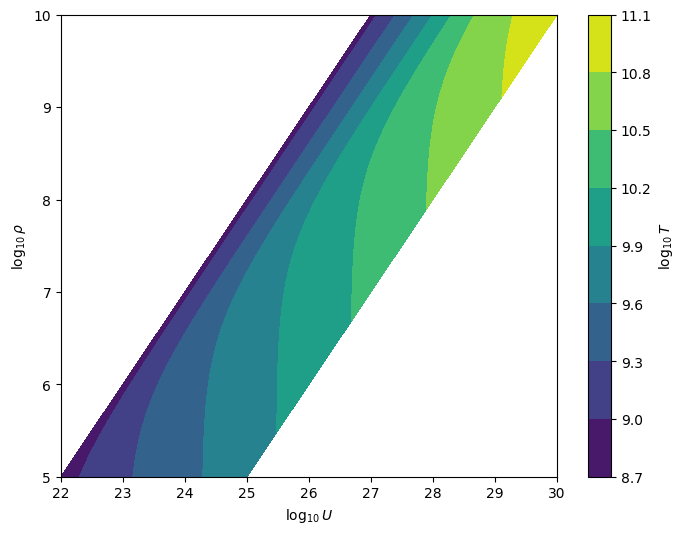

In [ ]:
# Plot the result
# Create a meshgrid for plotting
espec_grid, rho_grid = np.meshgrid(espec, rho, indexing="ij")


# Create a contour plot
plt.figure(figsize=(8, 6))
plt.contourf(np.log10(espec_grid*rho_grid), np.log10(rho_grid), np.log10(t_values), cmap='viridis')
plt.colorbar(label=r'$\log_{10}T$')
plt.xlabel(r'$\log_{10}U$')
plt.ylabel(r'$\log_{10}\rho$')
#plt.title('P vs. U and rho')
plt.show()


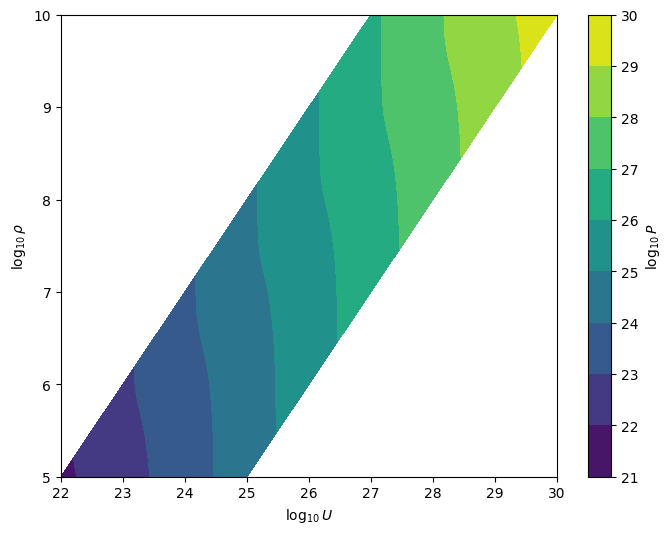

In [ ]:
# Plot the result
# Create a meshgrid for plotting
espec_grid, rho_grid = np.meshgrid(espec, rho, indexing="ij")


# Create a contour plot
plt.figure(figsize=(8, 6))
plt.contourf(np.log10(espec_grid*rho_grid), np.log10(rho_grid), np.log10(p_values), cmap='viridis')
plt.colorbar(label=r'$\log_{10}P$')
plt.xlabel(r'$\log_{10}U$')
plt.ylabel(r'$\log_{10}\rho$')
#plt.title('P vs. U and rho')
plt.show()


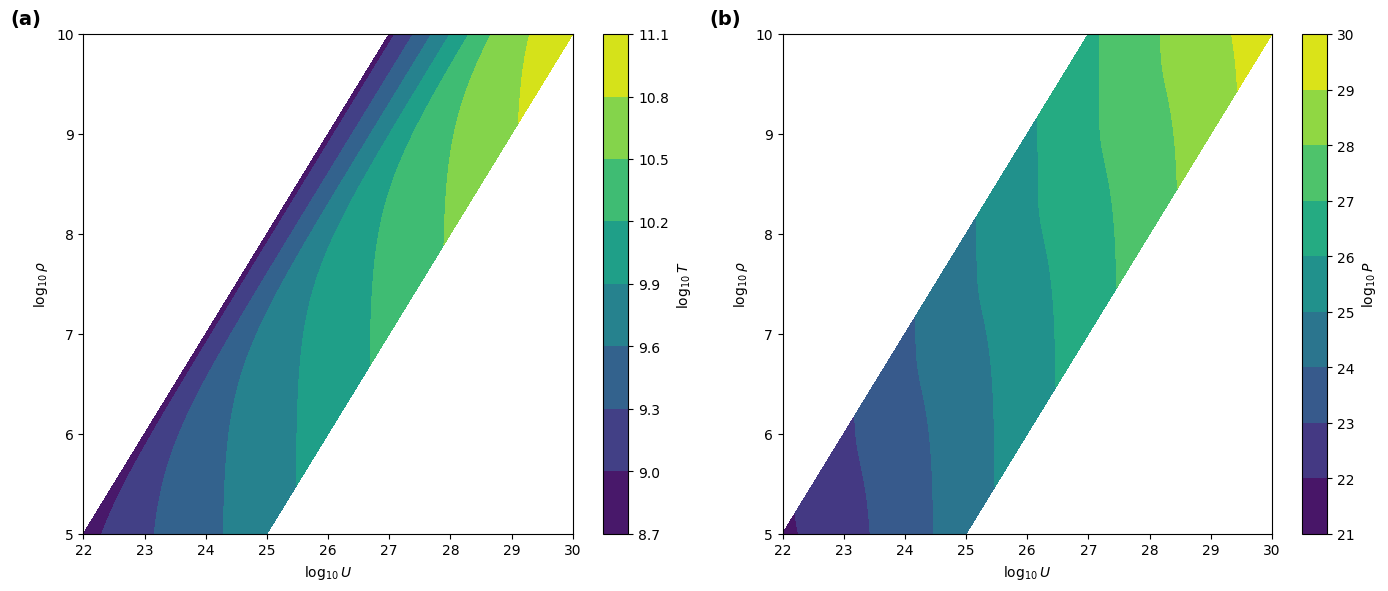

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Combine the two plots

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# -------- (a) Contour for log10(T) --------
cf1 = axs[0].contourf(np.log10(espec_grid * rho_grid), np.log10(rho_grid), np.log10(t_values), cmap='viridis')
cbar1 = fig.colorbar(cf1, ax=axs[0])
cbar1.set_label(r'$\log_{10}T$')
axs[0].set_xlabel(r'$\log_{10}U$')
axs[0].set_ylabel(r'$\log_{10}\rho$')
axs[0].annotate("(a)", xy=(-0.15, 1.05), xycoords='axes fraction',
                fontsize=14, fontweight='bold', va='top', ha='left')

# -------- (b) Contour for log10(P) --------
cf2 = axs[1].contourf(np.log10(espec_grid * rho_grid), np.log10(rho_grid), np.log10(p_values), cmap='viridis')
cbar2 = fig.colorbar(cf2, ax=axs[1])
cbar2.set_label(r'$\log_{10}P$')
axs[1].set_xlabel(r'$\log_{10}U$')
axs[1].set_ylabel(r'$\log_{10}\rho$')
axs[1].annotate("(b)", xy=(-0.15, 1.05), xycoords='axes fraction',
                fontsize=14, fontweight='bold', va='top', ha='left')

# -------- Layout and Save --------
plt.tight_layout()
plt.savefig("logT_logP_contours.pdf", bbox_inches='tight')
plt.show()


For given U, rho, after deriving P (rho, U), Gamma(rho, U) can also be derived from Gamma (rho, P).

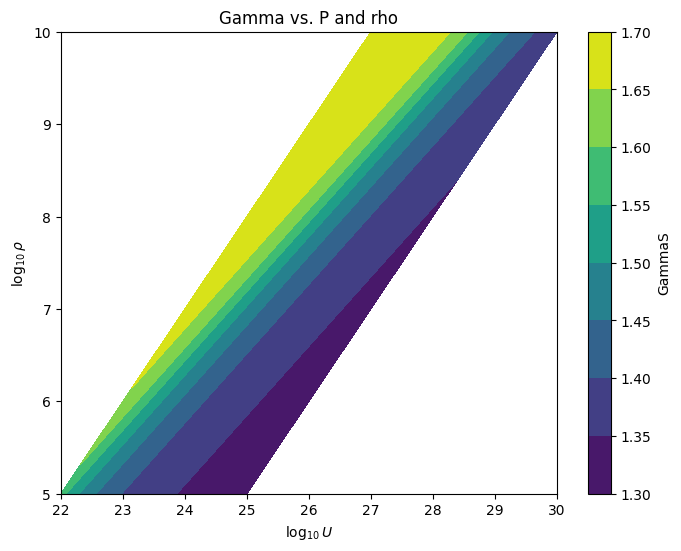

1.3358057290495946
1.66666399730724


In [ ]:
asq_values = []
# Loop through espec and rho to compute asq
for e_r in espec:  ###
    asq_row = []  # to store asq values for the current e
    for r in rho:
        p = pressure_function(r, e_r*r)[0]  # e*r is taken as e when calculating p
        asq = gamma_function(r, p)[0]  # Compute gamma


        # Append the computed value of asq for the current pair (e, rho)
        asq_row.append(asq)


    # Append the row of asq values for the current e
    asq_values.append(asq_row)

# Convert the list of lists to a numpy array for easier manipulation
asq_values = np.array(asq_values)
# Plot the result
# Create a meshgrid for plotting
espec_grid, rho_grid = np.meshgrid(espec, rho, indexing="ij")

# Create a contour plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(np.log10(espec_grid*rho_grid), np.log10(rho_grid), asq_values, cmap='viridis')
plt.colorbar(cp, label='GammaS')
plt.xlabel(r'$\log_{10}U$')
plt.ylabel(r'$\log_{10}\rho$')
plt.title('Gamma vs. P and rho')
# -------- Layout and Save --------
plt.tight_layout()
plt.savefig("gamma_Urho.pdf", bbox_inches='tight')
plt.show()

print(np.min(asq_values)) #minimum should approach 4/3

print(np.max(asq_values)) #maximum should approach 5/3

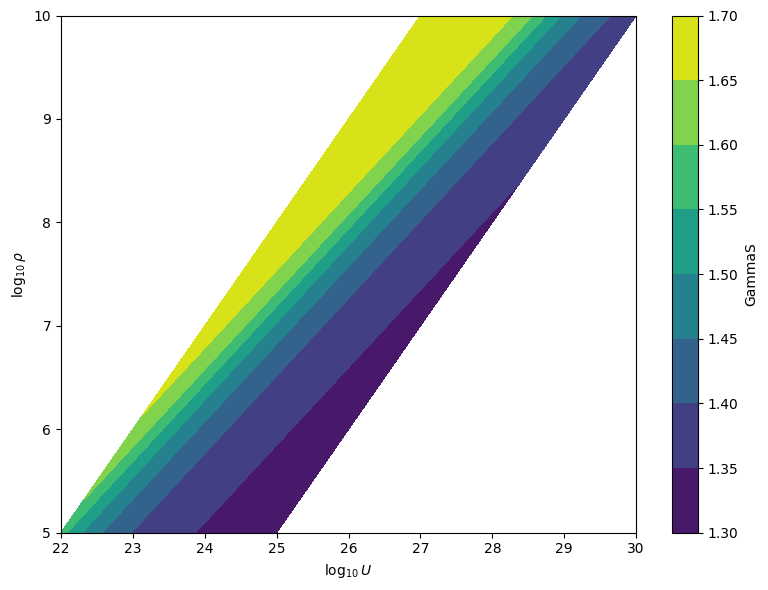

In [ ]:
# Create a contour plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(np.log10(espec_grid*rho_grid), np.log10(rho_grid), asq_values, cmap='viridis')
plt.colorbar(cp, label='GammaS')
plt.xlabel(r'$\log_{10}U$')
plt.ylabel(r'$\log_{10}\rho$')
#plt.title('Gamma vs. P and rho')
# -------- Layout and Save --------
plt.tight_layout()
plt.savefig("gamma_Urho.pdf", bbox_inches='tight')
plt.show()

The calculations of P and Gamma above use the "linear" interpolation.
Here we analyze the accuracy and consider both "linear" and "cubic" interpolations (for calculating P.)

In [ ]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import root_scalar

# === Constants ===
me = 9.11e-28
c = 3.0e10
kb = 1.38e-16
mp = 1.67e-24
arad = 7.56e-15
eV = 1.602e-12

# === True P(U,rho) Solver ===
def solve_T_given_U_rho(U_target, rho_target):
    def energy_balance(T):
        return 1.5 * (kb/mp) * rho_target * T + arad * T**4 - U_target
    Tmin, Tmax = 1e5, 1e12
    sol = root_scalar(energy_balance, bracket=(Tmin, Tmax), method='brentq')
    return sol.root

### to compare we need to derive the true P value
def compute_true_P(espec, rho):
    true_p_values = np.zeros((len(espec), len(rho)))
    for i, u_r in enumerate(espec):
        for j, r in enumerate(rho):
            U_val = u_r * r
            T_val = solve_T_given_U_rho(U_val, r)
            P_val = (kb/mp) * r * T_val + (1/3) * arad * T_val**4
            true_p_values[i, j] = P_val
    return true_p_values

# === Main Fast Function ===
def compute_interpolation_error(Ns=[20, 50, 100], method_list=["linear", "cubic"], n_test=200,
                                 rhomin=1e5, rhomax=1e12, tempMeVmin=0.01, tempMeVmax=30.0):
    """
    Compute interpolation errors for pressure P(rho, U) with different training grid sizes Ns.
    Vectorized over fine grid for fast evaluation.
    """

    errors = {method: [] for method in method_list}

    # === Fixed fine testing grid (n_test x n_test) ===
    log_espec_test = np.linspace(17.0, 20.0, n_test)
    log_rho_test = np.linspace(5.0, 10.0, n_test)
    espec_test = 10**log_espec_test
    rho_test = 10**log_rho_test

    # Precompute fine mesh for testing
    espec_grid_test, rho_grid_test = np.meshgrid(espec_test, rho_test, indexing='ij')
    U_grid_test = espec_grid_test * rho_grid_test

    true_p_values = compute_true_P(espec_test, rho_test)

    # === Loop over different training grid sizes ===
    for N in Ns:
        # Coarse training grid
        rhorun_N = np.logspace(np.log10(rhomin), np.log10(rhomax), N)
        temprun_N = np.logspace(np.log10(tempmin), np.log10(tempmax), N)

        temp2D_N, rho2D_N = np.meshgrid(temprun_N, rhorun_N, indexing="ij")

        P_table_N = rho2D_N * kb/mp * temp2D_N + arad * temp2D_N**4/3
        U_table_N = 1.5 * rho2D_N * kb/mp * temp2D_N + arad * temp2D_N**4

        log_rho_axis_N = np.log10(rho2D_N[0])
        log_temp_axis_N = np.log10(temp2D_N.T[0])

        # Define interpolators
        def build_logreginterpP_N(method="linear"):
            return RegularGridInterpolator((log_rho_axis_N, log_temp_axis_N), np.log10(P_table_N.T),
                                            method=method, bounds_error=False, fill_value=None)

        def build_logreginterpE_N(method="linear"):
            return RegularGridInterpolator((log_rho_axis_N, log_temp_axis_N), np.log10(U_table_N.T),
                                            method=method, bounds_error=False, fill_value=None)

        # Vectorized temperature solving to be fast
        def solve_log_temperatureErho_vectorized(E_grid, rho_grid, method="linear"):
            interpE = build_logreginterpE_N(method)

            def solve_one(rho_val, E_val):
                def root_func(log_T):
                    return interpE([np.log10(rho_val), log_T]) - np.log10(E_val)
                sol = root_scalar(root_func, bracket=(log_temp_axis_N.min(), log_temp_axis_N.max()), method="brentq")
                return sol.root

            solve_vec = np.vectorize(solve_one)
            log_T_grid = solve_vec(rho_grid, E_grid)
            return log_T_grid

        # === Now test ===
        for method in method_list:
            interpP = build_logreginterpP_N(method)

            # Solve log(T) over all points (vectorized)
            log_T_grid_test = solve_log_temperatureErho_vectorized(U_grid_test, rho_grid_test, method=method)

            # Interpolate P over all test points (vectorized)
            log_rho_grid = np.log10(rho_grid_test)
            points = np.stack([log_rho_grid.ravel(), log_T_grid_test.ravel()], axis=-1)
            logP_interp_flat = interpP(points)
            logP_interp_grid = logP_interp_flat.reshape(n_test, n_test)

            # Compute L2 error
            l2_err = np.sqrt(np.mean((np.log10(true_p_values) - logP_interp_grid)**2))
            errors[method].append(l2_err)

    return Ns, errors


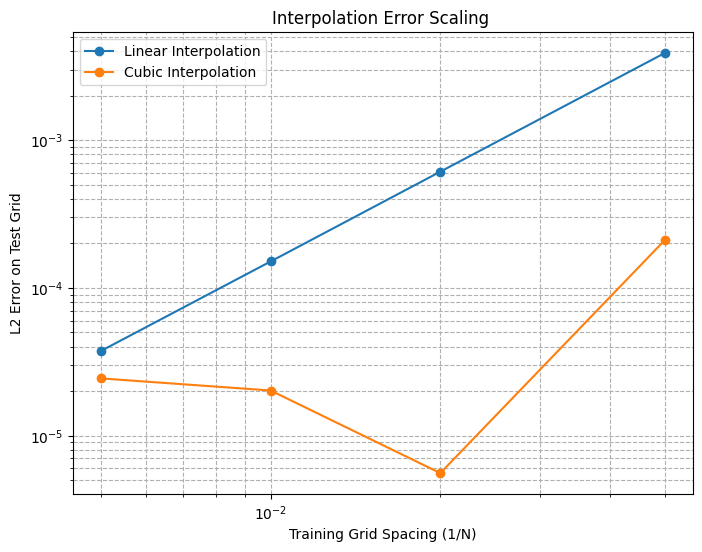

In [ ]:

# Plot
Ns, errors = compute_interpolation_error(Ns=[20, 50, 100, 200], method_list=["linear", "cubic"], n_test=300)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for method in errors.keys():
    plt.loglog(1/np.array(Ns), errors[method], 'o-', label=f'{method.capitalize()} Interpolation')
plt.xlabel('Training Grid Spacing (1/N)')
plt.ylabel('L2 Error on Test Grid')
plt.title('Interpolation Error Scaling ')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

The linear method error decreases smoothly with N. But the cubic method error first decreases and then gets worse as N increases, which is very strange. We learned that this is because the "cubic" method in RegularGridInterpolator is not a true spline interpolation. It actually uses local cubic polynomials that are only 1D and piecewise. It does not guarantee continuity (second derivative smoothness) across grid cells. Therefore, when the table becomes finer, the interpolated second derivatives can oscillate unpredictably and cause instability, which is a known behavior for local cubic interpolators.

To resolve this issue, we use RectBivariateSpline for "cubic", which does the global spline fitting and guarantees the smoothness.


In [ ]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator, RectBivariateSpline, interp1d
from scipy.optimize import root_scalar

In [ ]:


# === Constants ===
me = 9.11e-28
c = 3.0e10
kb = 1.38e-16
mp = 1.67e-24
arad = 7.56e-15
eV = 1.602e-12

# === True P(U,rho) Solver ===
def solve_T_given_U_rho(U_target, rho_target):
    def energy_balance(T):
        return 1.5 * (kb/mp) * rho_target * T + arad * T**4 - U_target
    Tmin, Tmax = 1e5, 1e12
    sol = root_scalar(energy_balance, bracket=(Tmin, Tmax), method='brentq')
    return sol.root

def compute_true_P(espec, rho):
    true_p_values = np.zeros((len(espec), len(rho)))
    for i, u_r in enumerate(espec):
        for j, r in enumerate(rho):
            U_val = u_r * r
            T_val = solve_T_given_U_rho(U_val, r)
            P_val = (kb/mp) * r * T_val + (1/3) * arad * T_val**4
            true_p_values[i, j] = P_val
    return true_p_values

# === Main Function ===
def compute_interpolation_error_new(Ns=[20, 50, 100], method_list=["linear", "cubic"], n_test=200,
                                 rhomin=1e5, rhomax=1e12, tempMeVmin=0.01, tempMeVmax=30.0):
    """
    Compute interpolation errors for P(rho, U/rho) using specified methods.
    Uses RegularGridInterpolator for 'linear' and RectBivariateSpline for 'cubic'.
    """

    errors = {method: [] for method in method_list}

    # === Step 1: Prepare the fine test grid (fixed) ===
    log_espec_test = np.linspace(17.0, 20.0, n_test)
    log_rho_test = np.linspace(5.0, 10.0, n_test)
    espec_test = 10**log_espec_test
    rho_test = 10**log_rho_test

    espec_grid_test, rho_grid_test = np.meshgrid(espec_test, rho_test, indexing='ij')
    U_grid_test = espec_grid_test * rho_grid_test

    true_p_values = compute_true_P(espec_test, rho_test)

    # === Step 2: Loop over different training grid sizes ===
    for N in Ns:
        # Coarse training grid
        rhorun_N = np.logspace(np.log10(rhomin), np.log10(rhomax), N)
        temprun_N = np.logspace(np.log10(tempmin), np.log10(tempmax), N)

        temp2D_N, rho2D_N = np.meshgrid(temprun_N, rhorun_N, indexing="ij")

        P_table_N = rho2D_N * kb/mp * temp2D_N + arad * temp2D_N**4/3
        U_table_N = 1.5 * rho2D_N * kb/mp * temp2D_N + arad * temp2D_N**4

        log_rho_axis_N = np.log10(rho2D_N[0])
        log_temp_axis_N = np.log10(temp2D_N.T[0])

        # Build interpolators depending on method
        def build_interpolators(method="linear"):
            if method == "linear":
                interpP = RegularGridInterpolator((log_rho_axis_N, log_temp_axis_N), np.log10(P_table_N.T),
                                                   method="linear", bounds_error=False, fill_value=None)
                interpE = RegularGridInterpolator((log_rho_axis_N, log_temp_axis_N), np.log10(U_table_N.T),
                                                   method="linear", bounds_error=False, fill_value=None)
            elif method == "cubic":
                interpP = RectBivariateSpline(log_rho_axis_N, log_temp_axis_N, np.log10(P_table_N.T))
                interpE = RectBivariateSpline(log_rho_axis_N, log_temp_axis_N, np.log10(U_table_N.T))
            else:
                raise ValueError(f"Unknown interpolation method: {method}")
            return interpP, interpE

        def solve_log_temperatureErho_vectorized(E_grid, rho_grid, interpE, method="linear"):
            def solve_one(rho_val, E_val):
                def root_func(log_T):
                    if method == "linear":
                        return interpE([np.log10(rho_val), log_T]) - np.log10(E_val)
                    elif method == "cubic":
                        return interpE.ev(np.log10(rho_val), log_T) - np.log10(E_val)
                sol = root_scalar(root_func, bracket=(log_temp_axis_N.min(), log_temp_axis_N.max()), method="brentq")
                return sol.root
            solve_vec = np.vectorize(solve_one)
            return solve_vec(rho_grid, E_grid)

        # === Step 3: Evaluate on fine test grid ===
        for method in method_list:
            interpP, interpE = build_interpolators(method)

            log_T_grid_test = solve_log_temperatureErho_vectorized(U_grid_test, rho_grid_test, interpE, method)

            log_rho_grid = np.log10(rho_grid_test)
            points = np.stack([log_rho_grid.ravel(), log_T_grid_test.ravel()], axis=-1)

            if method == "linear":
                logP_interp_flat = interpP(points)
            elif method == "cubic":
                logP_interp_flat = interpP.ev(points[:,0], points[:,1])

            logP_interp_grid = logP_interp_flat.reshape(n_test, n_test)

            l2_err = np.sqrt(np.mean((np.log10(true_p_values) - logP_interp_grid)**2))
            errors[method].append(l2_err)

    return Ns, errors


Linear interpolation: fitted convergence rate = 2.02
Cubic interpolation: fitted convergence rate = 4.43


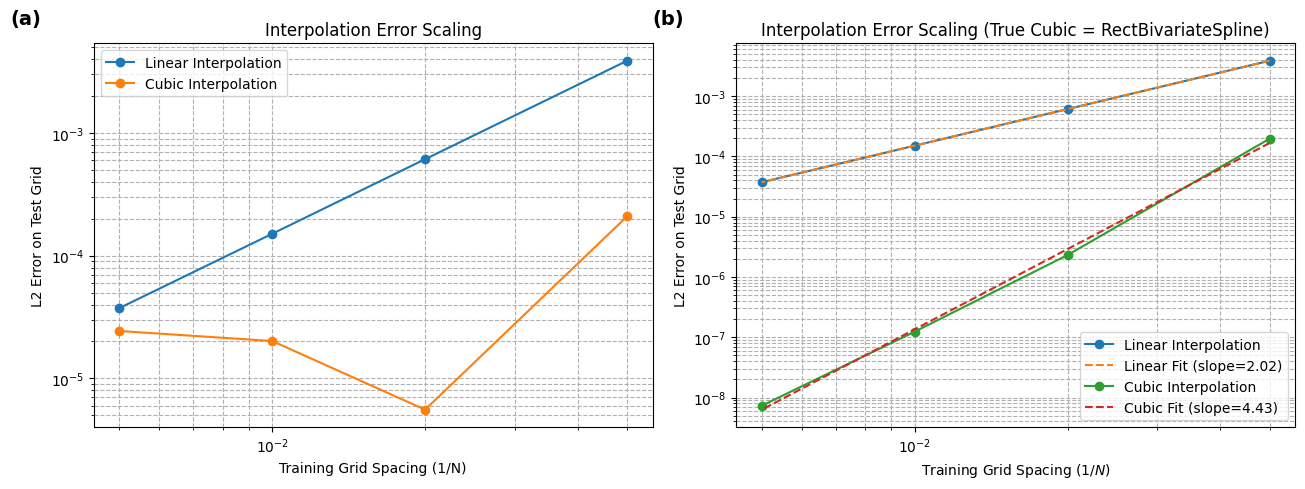

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# --- Call the first compute_interpolation_error (original) ---
Ns1, errors1 = Ns, errors

# --- Call the second compute_interpolation_error (new version) ---
Ns2, errors2 = compute_interpolation_error_new(Ns=[20, 50, 100, 200], method_list=["linear", "cubic"], n_test=300)

inv_Ns1 = 1 / np.array(Ns1)
inv_Ns2 = 1 / np.array(Ns2)


# --- Create subplots ---
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# -------- (a) Original Interpolation Error Plot --------
for method in errors1.keys():
    axs[0].loglog(inv_Ns1, errors1[method], 'o-', label=f'{method.capitalize()} Interpolation')

axs[0].set_xlabel('Training Grid Spacing (1/N)')
axs[0].set_ylabel('L2 Error on Test Grid')
axs[0].legend()
axs[0].grid(True, which="both", ls="--")
axs[0].set_title('Interpolation Error Scaling')

# -------- (b) New Version with Fitted Slopes --------
for method in errors2.keys():
    axs[1].loglog(inv_Ns2, errors2[method], 'o-', label=f'{method.capitalize()} Interpolation')

    # Slope fitting
    log_inv_Ns = np.log10(inv_Ns2)
    log_err = np.log10(errors2[method])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(log_inv_Ns, log_err)
    print(f"{method.capitalize()} interpolation: fitted convergence rate = {slope:.2f}")

    # Plot fitted line
    fitted_log_err = intercept + slope * log_inv_Ns
    axs[1].plot(inv_Ns2, 10**fitted_log_err, '--', label=f'{method.capitalize()} Fit (slope={slope:.2f})')

axs[1].set_xlabel(r'Training Grid Spacing $(1/N)$')
axs[1].set_ylabel('L2 Error on Test Grid')
axs[1].legend()
axs[1].grid(True, which="both", ls="--")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Interpolation Error Scaling (True Cubic = RectBivariateSpline)')

# -------- Add subplot labels --------
axs[0].annotate("(a)", xy=(-0.15, 1.05), xycoords='axes fraction', fontsize=14, fontweight='bold')
axs[1].annotate("(b)", xy=(-0.15, 1.05), xycoords='axes fraction', fontsize=14, fontweight='bold')

# -------- Finalize --------
plt.tight_layout()
plt.savefig("combined_interpolation_comparison.pdf", bbox_inches='tight')
plt.show()


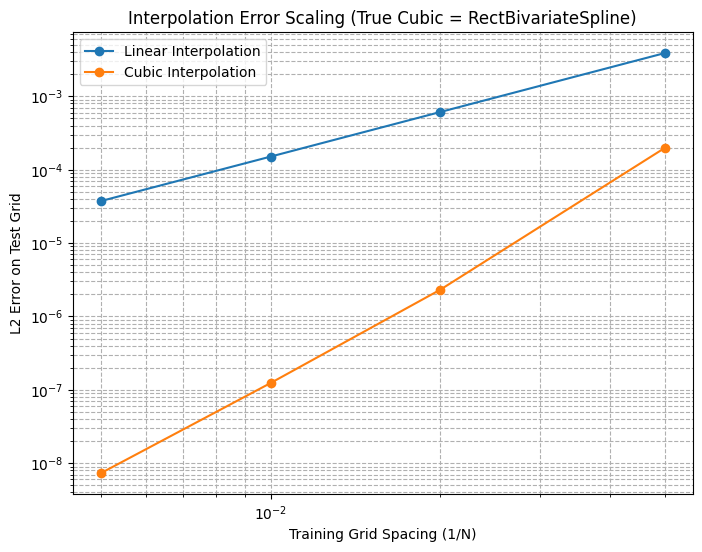

In [ ]:
# Compute interpolation errors
Ns, errors = compute_interpolation_error_new(Ns=[20, 50, 100, 200], method_list=["linear", "cubic"], n_test=300)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for method in errors.keys():
    plt.loglog(1/np.array(Ns), errors[method], 'o-', label=f'{method.capitalize()} Interpolation')
plt.xlabel('Training Grid Spacing (1/N)')
plt.ylabel('L2 Error on Test Grid')
plt.title('Interpolation Error Scaling (True Cubic = RectBivariateSpline)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


We further do a fitting to see the convergence rate. The results below show that the "linear" and "cubic" methods have $\mathcal{O}(1/N^2)$ and $\mathcal{O}(1/N^4)$ convergence, respectively, consistent with what we expect from the leading errors.


\begin{array}{c|c|c|c}
\textbf{Method} & \textbf{Approximation} & \textbf{Leading Error} & \textbf{Convergence} \\
\hline
\text{Linear} & \text{Straight lines between points} & f''(x) \text{ term} & \mathcal{O}(1/N^2) \\
\text{Cubic spline} & \text{Smooth cubic curves} & f^{(4)}(x) \text{ term} & \mathcal{O}(1/N^4) \\
\end{array}




Linear interpolation: fitted convergence rate = 2.02
Cubic interpolation: fitted convergence rate = 4.43


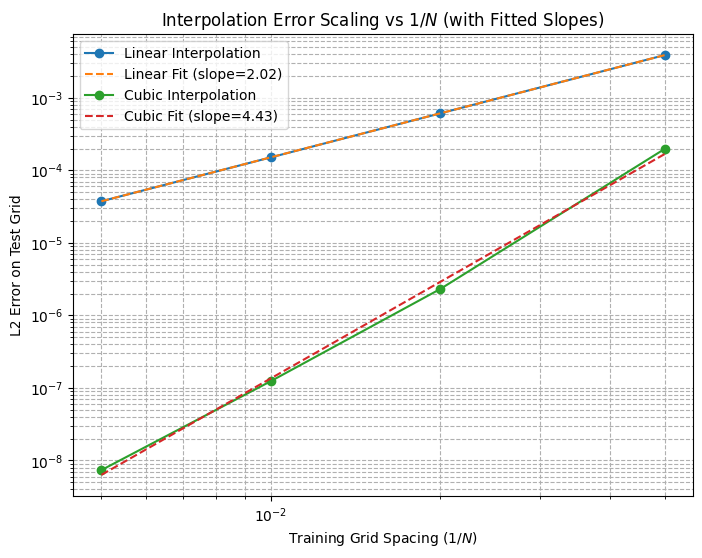

In [ ]:
import scipy.stats
# === After computing Ns, errors ===

inv_Ns = 1 / np.array(Ns)  # 1/N

plt.figure(figsize=(8,6))
for method in errors.keys():
    plt.loglog(inv_Ns, errors[method], 'o-', label=f'{method.capitalize()} Interpolation')

    # Automatic slope fitting
    log_inv_Ns = np.log10(inv_Ns)
    log_err = np.log10(errors[method])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(log_inv_Ns, log_err)

    print(f"{method.capitalize()} interpolation: fitted convergence rate = {slope:.2f}")

    # Plot fitted line for reference
    fitted_log_err = intercept + slope * log_inv_Ns
    plt.plot(inv_Ns, 10**fitted_log_err, '--', label=f'{method.capitalize()} Fit (slope={slope:.2f})')

plt.xlabel(r'Training Grid Spacing $(1/N)$')
plt.ylabel('L2 Error on Test Grid')
plt.title('Interpolation Error Scaling vs $1/N$ (with Fitted Slopes)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xscale('log')
plt.yscale('log')
plt.show()


### Finally we analyze the error in  Gamma($\rho$, U)

The error here has contribution from not only the interpolation from the known data points to the target points but also the differentiation. We see that to achieve high accuracy in Gamma, one needs to apply high-order methods in both the interpolation and the differentation.

In [ ]:
def gamma_exact_func(rho, T, P):
    return dPdrho_S_exact(rho, T)*rho/P


# === Main function: Gamma interpolation + differentiation error ===
def compute_gamma_error_new(Ns=[20, 50, 100], method_list=["linear", "cubic"], diff_methods=["central", "fourth_order_central"],
                            n_test=200, rhomin=1e5, rhomax=1e12, tempMeVmin=0.01, tempMeVmax=30.0):
    """
    Compute interpolation errors for Gamma using specified methods.
    Uses RegularGridInterpolator for 'linear' and RectBivariateSpline for 'cubic'.
    """

    #errors = {method: [] for method in method_list}
    errors = {(interp, diff): [] for interp in method_list for diff in diff_methods}


    # === Step 1: Prepare the fine test grid (fixed) ===
    log_espec_test = np.linspace(17.0, 20.0, n_test)
    log_rho_test = np.linspace(5.0, 10.0, n_test)
    espec_test = 10**log_espec_test
    rho_test = 10**log_rho_test

    espec_grid_test, rho_grid_test = np.meshgrid(espec_test, rho_test, indexing='ij')
    U_grid_test = espec_grid_test * rho_grid_test

    true_p_values = compute_true_P(espec_test, rho_test)
    true_temp_values = np.vectorize(solve_T_given_U_rho)(U_grid_test, rho_grid_test)
    true_gamma_values = gamma_exact_func(rho_grid_test, true_temp_values, true_p_values)



    # === Step 2: Loop over different training grid sizes ===
    for N in Ns:
        # Coarse training grid
        rhorun_N = np.logspace(np.log10(rhomin), np.log10(rhomax), N)
        temprun_N = np.logspace(np.log10(tempmin), np.log10(tempmax), N)

        temp2D_N, rho2D_N = np.meshgrid(temprun_N, rhorun_N, indexing="ij")

        P_table_N = rho2D_N * kb/mp * temp2D_N + arad * temp2D_N**4/3
        U_table_N = 1.5 * rho2D_N * kb/mp * temp2D_N + arad * temp2D_N**4

        log_rho_axis_N = np.log10(rho2D_N[0])
        log_temp_axis_N = np.log10(temp2D_N.T[0])

        # Build interpolators depending on method
        def build_interpolators(method="linear"):
            if method == "linear":
                interpP = RegularGridInterpolator((log_rho_axis_N, log_temp_axis_N), np.log10(P_table_N.T),
                                                   method="linear", bounds_error=False, fill_value=None)
                interpE = RegularGridInterpolator((log_rho_axis_N, log_temp_axis_N), np.log10(U_table_N.T),
                                                   method="linear", bounds_error=False, fill_value=None)
            elif method == "cubic":
                interpP = RectBivariateSpline(log_rho_axis_N, log_temp_axis_N, np.log10(P_table_N.T))
                interpE = RectBivariateSpline(log_rho_axis_N, log_temp_axis_N, np.log10(U_table_N.T))
            else:
                raise ValueError(f"Unknown interpolation method: {method}")
            return interpP, interpE

        def solve_log_temperatureErho_vectorized(E_grid, rho_grid, interpE, method="linear"):
            def solve_one(rho_val, E_val):
                def root_func(log_T):
                    if method == "linear":
                        return interpE([np.log10(rho_val), log_T]) - np.log10(E_val)
                    elif method == "cubic":
                        return interpE.ev(np.log10(rho_val), log_T) - np.log10(E_val)
                sol = root_scalar(root_func, bracket=(log_temp_axis_N.min(), log_temp_axis_N.max()), method="brentq")
                return sol.root
            solve_vec = np.vectorize(solve_one)
            return solve_vec(rho_grid, E_grid)



        # # === Step 3: Evaluate on fine test grid ===
        for interp_method in method_list:
            interpP, interpE = build_interpolators(interp_method)

            # Step 1: Solve for log10(T)
            log_T_grid_test = solve_log_temperatureErho_vectorized(U_grid_test, rho_grid_test, interpE, interp_method)
            T_grid_test = 10**log_T_grid_test

            # Step 2: Prepare interpolation points
            log_rho_grid = np.log10(rho_grid_test)
            points = np.stack([log_rho_grid.ravel(), log_T_grid_test.ravel()], axis=-1)

            # Step 3: Interpolate P and U on test grid
            if interp_method == "linear":
                P_interp_grid = 10**interpP(points).reshape(n_test, n_test)
                U_interp_grid = 10**interpE(points).reshape(n_test, n_test)
            elif interp_method == "cubic":
                P_interp_grid = 10**interpP.ev(points[:, 0], points[:, 1]).reshape(n_test, n_test)
                U_interp_grid = 10**interpE.ev(points[:, 0], points[:, 1]).reshape(n_test, n_test)

            # Step 4: Compute approximate gamma using differentiation
            for diff_method in diff_methods:
                gamma_approx = compute_dPdrho_Sv2(
                    rho_test, T_grid_test[:, 0], P_interp_grid, U_interp_grid, method=diff_method
                ) * rho_grid_test / P_interp_grid

                # Step 5: Compute L2 error
                l2_err = np.sqrt(np.mean((gamma_approx - true_gamma_values)**2))
                errors[(interp_method, diff_method)].append(l2_err)


    return Ns, errors


In [ ]:

Ns, errors = compute_gamma_error_new(
    Ns=[20, 50, 100, 200],
    method_list=["linear", "cubic"],
    diff_methods=["central", "fourth_order_central"]
)

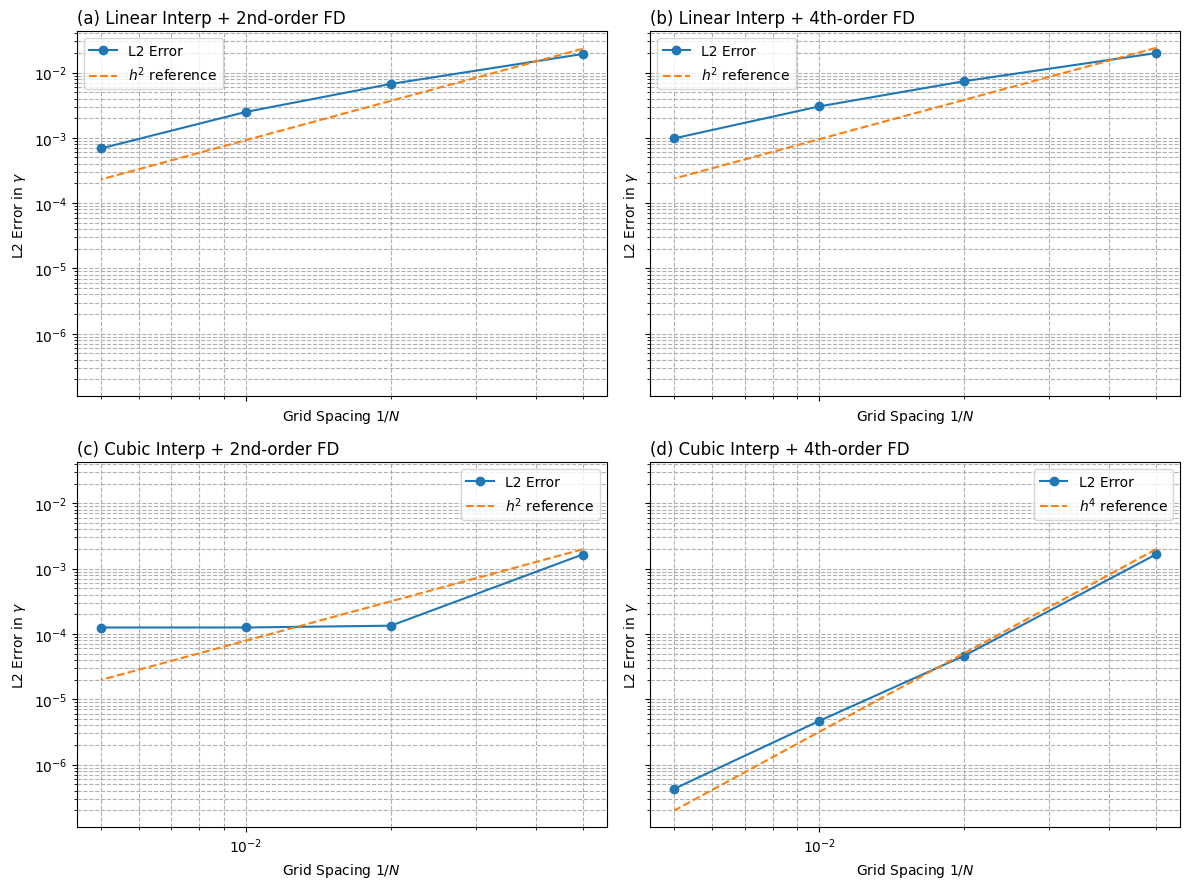

In [ ]:


# Prepare for plotting
inv_Ns = 1 / np.array(Ns)

fig, axs = plt.subplots(2, 2, figsize=(12, 9), sharex=True, sharey=True)

method_pairs = [
    ("linear", "central"),
    ("linear", "fourth_order_central"),
    ("cubic", "central"),
    ("cubic", "fourth_order_central"),
]

titles = {
    ("linear", "central"): "(a) Linear Interp + 2nd-order FD",
    ("linear", "fourth_order_central"): "(b) Linear Interp + 4th-order FD",
    ("cubic", "central"): "(c) Cubic Interp + 2nd-order FD",
    ("cubic", "fourth_order_central"): "(d) Cubic Interp + 4th-order FD",
}

for ax, key in zip(axs.flat, method_pairs):
    err_vals = np.array(errors[key])
    slope = 2 if key[1] == "central" or key[0] == "linear" else 4
    ref_line = 1.2*err_vals[0] * (inv_Ns / inv_Ns[0])**slope

    ax.loglog(inv_Ns, err_vals, 'o-', label='L2 Error')
    ax.loglog(inv_Ns, ref_line, '--', label=f"$h^{slope}$ reference")
    ax.set_title(titles[key], loc='left')
    ax.set_xlabel("Grid Spacing $1/N$")
    ax.set_ylabel("L2 Error in $\\gamma$")
    ax.grid(True, which='both', ls='--')
    ax.legend()
# -------- Finalize --------
plt.tight_layout()
plt.savefig("gamma_Urho_err.pdf", bbox_inches='tight')
plt.show()


In [ ]:
##generate Equation of State table readable for Athena++


import numpy as np

def generate_athenaeos_table(log_espec_lim, log_rho_lim, n_espec, n_rho, filename,energy_function, gamma_function, pressure_function):
    """
    Generates an EOS table and writes it to a .tab file.

    Parameters:
        log_espec_lim (list): [min, max] log10 limits for e/rho.
        log_rho_lim (list): [min, max] log10 limits for rho.
        n_espec (int): Number of points in e/rho direction.
        n_rho (int): Number of points in rho direction.
        filename (str): Output file name (.tab).
        energy_function (callable): Function to compute pressure or energy.
        gamma_function (callable): Function to compute gamma.
    """
    log_espec = np.linspace(log_espec_lim[0], log_espec_lim[1], n_espec)
    log_rho = np.linspace(log_rho_lim[0], log_rho_lim[1], n_rho)
    espec = 10 ** log_espec
    rho = 10 ** log_rho

    log_p_e = np.zeros((n_espec, n_rho))
    log_e_p = np.zeros((n_espec, n_rho))
    log_asq_rho_p = np.zeros((n_espec, n_rho))

    for i, e in enumerate(espec):
        for j, r in enumerate(rho):
            try:
                p = energy_function(r, e * r)   # e*r passed as e
                g_energy = energy_function(r, e * r)  # e*r passed as p
                asq = gamma_function(r, e * r)  # e*r passed as p

                log_p_e[i, j] = np.log10(p / (e * r))
                log_e_p[i, j] = np.log10(g_energy / (e * r))
                log_asq_rho_p[i, j] = np.log10(asq)
            except Exception:
                log_p_e[i, j] = 0.0
                log_e_p[i, j] = 0.0
                log_asq_rho_p[i, j] = 0.0

    with open(filename, 'w') as f:
      # Entries must be space separated.
        f.write(f"{4} {n_espec} {n_rho}\n")
        f.write("# Log espec lim\n")
        f.write(f"{log_espec_lim[0]:.4e} {log_espec_lim[1]:.4e}\n")
        f.write("# Log rho lim\n")
        f.write(f"{log_rho_lim[0]:.4e} {log_rho_lim[1]:.4e}\n")

        f.write("# Log p/e(e/rho,rho)\n")
        for row in log_p_e:
            f.write(" ".join(f"{val:.4e}" for val in row) + "\n")

        f.write("# Log e/p(p/rho,rho)\n")
        for row in log_e_p:
            f.write(" ".join(f"{val:.4e}" for val in row) + "\n")

        f.write("# Log asq*rho/p(p/rho,rho)\n")
        for row in log_asq_rho_p:
            f.write(" ".join(f"{val:.4e}" for val in row) + "\n")

    print(f"EOS table written to {filename}")



In [ ]:
generate_athenaeos_table([17, 20], [5, 10], 50, 50, "eddington.tab", energy_function, gamma_function, pressure_function)

<ipython-input-14-f783f0b2ce7f>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_p_e[i, j] = np.log10(p / (e * r))
<ipython-input-14-f783f0b2ce7f>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_e_p[i, j] = np.log10(g_energy / (e * r))
<ipython-input-14-f783f0b2ce7f>:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_asq_rho_p[i, j] = np.log10(asq)


EOS table written to eddington.tab


In [ ]:
#read the data structure

with open('eddington.tab') as f:
    for line in f:
        print(line)

4 50 50

# Log espec lim

1.7000e+01 2.0000e+01

# Log rho lim

5.0000e+00 1.0000e+01

# Log p/e(e/rho,rho)

2.5896e-01 2.5048e-01 2.4225e-01 2.3438e-01 2.2694e-01 2.2002e-01 2.1366e-01 2.0792e-01 2.0281e-01 1.9834e-01 1.9447e-01 1.9116e-01 1.8838e-01 1.8605e-01 1.8413e-01 1.8256e-01 1.8127e-01 1.8023e-01 1.7939e-01 1.7872e-01 1.7818e-01 1.7775e-01 1.7741e-01 1.7714e-01 1.7692e-01 1.7675e-01 1.7661e-01 1.7650e-01 1.7642e-01 1.7635e-01 1.7629e-01 1.7625e-01 1.7622e-01 1.7619e-01 1.7617e-01 1.7615e-01 1.7614e-01 1.7613e-01 1.7612e-01 1.7612e-01 1.7611e-01 1.7611e-01 1.7610e-01 1.7610e-01 1.7610e-01 1.7610e-01 1.7610e-01 1.7610e-01 1.7609e-01 1.7609e-01

2.7461e-01 2.6588e-01 2.5725e-01 2.4881e-01 2.4065e-01 2.3285e-01 2.2551e-01 2.1870e-01 2.1247e-01 2.0685e-01 2.0187e-01 1.9751e-01 1.9376e-01 1.9056e-01 1.8788e-01 1.8564e-01 1.8379e-01 1.8228e-01 1.8105e-01 1.8005e-01 1.7925e-01 1.7860e-01 1.7809e-01 1.7768e-01 1.7735e-01 1.7709e-01 1.7688e-01 1.7672e-01 1.7659e-01 1.7648e-01 1.7640e-01